# WNTR Geospatial Tutorial
The following tutorial illustrates the use of the `wntr.gis` module to use geospatial data in resilience analysis.  The objective of this tutorial is to 1) quantify water service disruptions that could occur from pipes damaged in landslides and 2) identify the social vulnerability of populations impacted by the service disruptions.

To simplify the tutorials, it is assumed that pipes within a 1000 ft buffer of each landslide susceptible region are damaged in that landslide.
This assumption could be replaced with detailed landslide analysis that includes slope, soil type, weather conditions, and pipe material.
Social vulnerability data could also be replaced by datasets that describe other attributes of the population and critical services.

## Imports
Install and import WNTR and additional Python packages that are needed for the tutorial
- Geopandas is used to load geospatial data
- Shapely is used to define a region of interest to crop data
- Matplotlib is used to create subplots

In [1]:
#!pip install geopandas==0.14.4 shapely matplotlib wntr

In [2]:
import geopandas as gpd
from shapely.geometry import box
import matplotlib.pylab as plt
import wntr

Create directories to hold results if they do not already exist

In [3]:
import os

if not os.path.isdir('geojsons'):
    os.makedirs('geojsons')

## Units
WNTR uses SI (International System) units (length in meters, time in seconds, mass in kilograms), **with the exception of the landslide buffer which is in feet to match the coordinate reference system of the geospatial data**.  See https://usepa.github.io/WNTR/units.html for more details on WNTR units.

In [4]:
# The following line defines coordinates used to zoom in on network graphics
zoom_coords = [(5.75e6, 5.79e6), (3.82e6, 3.85e6)] 

# Water Network Model
The following section creates a `WaterNetworkModel` object from an EPANET INP file and converts the model to GeoDataFrames for use in geospatial analysis.

## Create a WaterNetworkModel from an EPANET INP file
The water distribution network model used in this tutorial was downloaded from the [UKnowledge Water Distribution Systems Research Database](https://uknowledge.uky.edu/wdsrd/). KY10 was selected for the analysis. The following section creates a `WaterNetworkModel` from an EPANET INP file and computes some general attributes of the model.

*Citation: Hoagland, Steven, "10 KY 10" (2016). Kentucky Dataset. 12. https://uknowledge.uky.edu/wdst/12. Accessed on 4/4/2024.*

In [5]:
# Create a WaterNetworkModel from an EPANET INP file
inp_file = 'networks/ky10.inp'
wn = wntr.network.WaterNetworkModel(inp_file)

In [6]:
# Print a basic description of the model. 
# The level can be 0, 1, or 2 and defines the level of detail included in the description.
wn.describe(level=1)

{'Nodes': {'Junctions': 920, 'Tanks': 13, 'Reservoirs': 2},
 'Links': {'Pipes': 1043, 'Pumps': 13, 'Valves': 5},
 'Patterns': 4,
 'Curves': {'Pump': 0, 'Efficiency': 0, 'Headloss': 0, 'Volume': 0},
 'Sources': 0,
 'Controls': 6}

In [7]:
# Compute total pipe length
length = wn.query_link_attribute('length')
total_length = length.sum() # m
print('Total pipe length =', total_length, 'm, =', total_length*3.28084, 'ft')

Total pipe length = 430025.7699696 m, = 1410845.7471470626 ft


In [8]:
# Compute average expected demand per day 
average_expected_demand = wntr.metrics.average_expected_demand(wn) # m^3/s
average_volume_per_day = average_expected_demand*(24*3600) # m^3
total_water_use = average_volume_per_day.sum() # m^3
print('Total water use =', total_water_use, 'm^3, =', total_water_use*264.172/1e6, 'million gallons')

Total water use = 8180.260818317952 m^3, = 2.16099586089669 million gallons


In [9]:
# Estimate population using the default average volume of water consumed per capita per day of 200 gallons/day
population = wntr.metrics.population(wn) 
total_population = population.sum()
print('Total population =', total_population)

Total population = 10799.0


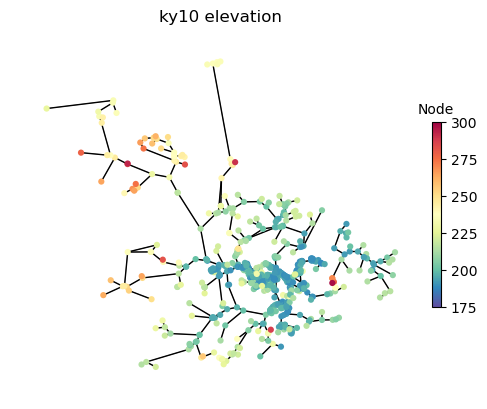

In [10]:
# Create a basic network graphic, showing junction elevation
# Note, the remaining graphics in this tutorial are created from the geospatial data directly, rather than the `plot_network` function.
# The `plot_network` function currently does not include vertices.
ax = wntr.graphics.plot_network(wn, node_attribute='elevation', node_range=(175, 300), title='ky10 elevation')

## Convert the WaterNetworkModel to GIS data
The `WaterNetworkModel` is converted to a collection of GIS compatible GeoDataFrames and the coordinate reference system (CRS) is set to **EPSG:3089 (NAD83 / Kentucky Single Zone (ftUS)**, see https://epsg.io/3089 for more details).  Data for junctions, tanks, reservoirs, pipes, pumps, and valves are stored in separate GeoDataFrames.

In [11]:
# Convert the WaterNetworkModel to GIS data and set the CRS
wn_gis = wn.to_gis()
wn_gis.junctions.head()
#wn_gis.tanks.head()
#wn_gis.reservoirs.head()
#wn_gis.pipes.head()
#wn_gis.pumps.head()


,node_type,elevation,initial_quality,geometry
J-1,Junction,218.079889,0.0,POINT (5765080.500 3843715.000)
J-10,Junction,244.449966,0.0,POINT (5763552.050 3874637.000)
J-100,Junction,195.045300,0.0,POINT (5759532.400 3834262.000)
J-101,Junction,213.592014,0.0,POINT (5755474.000 3830288.000)
J-102,Junction,189.579382,0.0,POINT (5774010.920 3832605.000)


In [12]:
# Set the CRS to EPSG:3089 (NAD83 / Kentucky Single Zone (ftUS))
crs = 'EPSG:3089'
wn_gis.set_crs(crs)

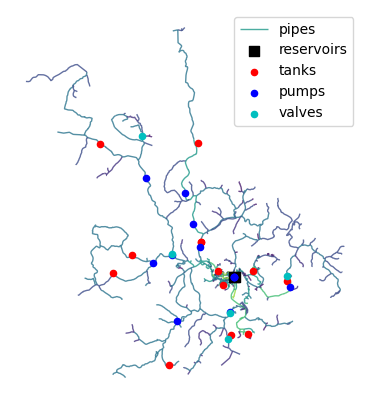

In [13]:
# Use the GIS data to create a figure of the network
fig, ax = plt.subplots(figsize=(5,5))
ax = wn_gis.pipes.plot(column='diameter', linewidth=1, label='pipes', alpha=0.8, ax=ax, zorder=1)
ax = wn_gis.reservoirs.plot(color='k', marker='s', markersize=60, label='reservoirs', ax=ax)
ax = wn_gis.tanks.plot(color='r', markersize=20, label='tanks', ax=ax)
ax = wn_gis.pumps.centroid.plot(color='b', markersize=20, label='pumps', ax=ax)
ax = wn_gis.valves.centroid.plot(color='c', markersize=20, label='valves', ax=ax)
tmp = ax.axis('off')
# Comment/uncomment the following 2 lines to change the zoom on the network graphic
#tmp = ax.set_xlim(zoom_coords[0])
#tmp = ax.set_ylim(zoom_coords[1])
tmp = plt.legend()

## Save the GIS data to GeoJSON or Shapefile files
The GIS data can be written to GeoJSON files or Shapefile files.  One file is created for junctions, tanks, reservoirs, pipes, pumps, and valves (ky10_junctions.geojson, ky10_tanks.geojson, etc.).  The GeoJSON or Shapefile files can be loaded into GIS software platforms for further analysis. **Note that controls, patterns, curves, and options are not included in the GIS formatted data files.** 

In [14]:
# Store the WaterNetworkModel as a collection of GeoJSON files
wn_gis.write_geojson('geojsons/ky10')

# External GIS Data
The external data used in this tutorial includes landslide inventory and social vulnerability data.

## Load landslide GIS data
The landslide data used in this tutorial was downloaded from the [UKnowledge Kentucky Geological Survey Research Data](https://uknowledge.uky.edu/kgs_data/).  The Kentucky Geological Survey Landslide Inventory from March 2023 was selected for the analysis.  The data contains locations of known landslides and areas susceptible to debris flows, derived from aerial photography. 

*Citation: Crawford, M.M., 2023. Kentucky Geological Survey landslide inventory [2023-03]: Kentucky Geological Survey Research Data, https://uknowledge.uky.edu/kgs_data/7/, Accessed on 4/4/2024.*

In [15]:
# To reduce the file size checked into the WNTR repository, the following code was run on the raw data file.
# The region of interest (ROI) includes a 5000 ft buffer surrounding all pipes. The function `box` was imported from shapely.
"""
bounds = wn_gis.pipes.total_bounds # total_bounds returns the upper and lower bounds on x and y
geom = box(*bounds)
ROI = geom.buffer(5000) # feet

landslide_file = '../data/KGS_Landslide_Inventory_exp.gdb'
landslide_data = gpd.read_file(landslide_file, driver="FileGDB", layer='Areas_derived_from_aerial_photography')
print(landslide_data.crs)
landslide_data = landslide_data.clip(ROI)
landslide_data.to_file("../data/ky10_landslide_data.geojson", index=True, driver='GeoJSON')
"""

'\nbounds = wn_gis.pipes.total_bounds # total_bounds returns the upper and lower bounds on x and y\ngeom = box(*bounds)\nROI = geom.buffer(5000) # feet\n\nlandslide_file = \'../data/KGS_Landslide_Inventory_exp.gdb\'\nlandslide_data = gpd.read_file(landslide_file, driver="FileGDB", layer=\'Areas_derived_from_aerial_photography\')\nprint(landslide_data.crs)\nlandslide_data = landslide_data.clip(ROI)\nlandslide_data.to_file("../data/ky10_landslide_data.geojson", index=True, driver=\'GeoJSON\')\n'

In [16]:
# Load the landslide data from file and print the CRS to ensure it is in EPSG:3089.  
# The methods `to_crs` and `set_crs` can be used to change coordinate reference systems if needed.
landslide_file = 'data/ky10_landslide_data.geojson'
landslide_data = gpd.read_file(landslide_file).set_index('index') 
print(landslide_data.crs)

landslide_data.head()

EPSG:3089


,Type,QUADRANGLE,Confidence_Ranking,Shape_Length,Shape_Area,geometry
index,,,,,,
12158,Landslide,LANCER,3,600.093659,25776.421953,"POLYGON ((5795711.138 3796524.413, 5795749.332..."
12154,Landslide,LANCER,3,525.280081,18705.404676,"POLYGON ((5793900.026 3796635.524, 5793945.165..."
7509,Landslide,Prestonsburg,3,331.655229,7830.582786,"POLYGON ((5769026.666 3797014.993, 5769050.971..."
7511,Landslide,Prestonsburg,3,518.984567,19344.352333,"POLYGON ((5776317.985 3797039.298, 5776324.930..."
7507,Landslide,Prestonsburg,3,339.472695,8168.150433,"POLYGON ((5767849.582 3797074.020, 5767866.943..."


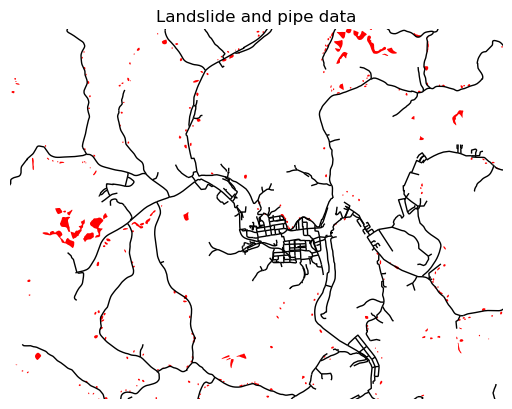

In [17]:
# Plot the landslide data along with pipes
ax = landslide_data.plot(color='red', label='Landslide data')
ax = wn_gis.pipes.plot(color='black', linewidth=1, ax=ax)
ax.set_title('Landslide and pipe data')
tmp = ax.axis('off')
# Comment/uncomment the following 2 lines to change the zoom on the network graphic
tmp = ax.set_xlim(zoom_coords[0])
tmp = ax.set_ylim(zoom_coords[1])

## Load Social Vulnerability Index (SVI) GIS data
The social vulnerability data used in this tutorial was downloaded from the [Centers for Disease Control and Prevention/Agency for Toxic Substances and Disease Registry](https://www.atsdr.cdc.gov/placeandhealth/svi/index.html). The data contains census and social vulnerability metrics for each census tract. 

The quantity of interest used in this analysis is `RPL_THEMES` which ranks vulnerability across socioeconomic status, household characteristics, racial and ethnic minority status, and housing type and transportation.  The value ranges between 0 and 1, where higher values are associated with higher vulnerability.

*Citation: Centers for Disease Control and Prevention/Agency for Toxic Substances and Disease Registry/Geospatial Research, Analysis, and Services Program. CDC/ATSDR Social Vulnerability Index 2020 Database Kentucky. https://www.atsdr.cdc.gov/placeandhealth/svi/data_documentation_download.html. Accessed on 4/4/2024.*

In [18]:
# To reduce the file size checked into the WNTR repository, the following code was run on the raw data file. 
# The region of interest (ROI) was defined above.
"""
svi_file = '../data/SVI2020_KENTUCKY_tract.gdb'
svi_data = gpd.read_file(svi_file, driver="FileGDB", layer='SVI2020_KENTUCKY_tract')
print(svi_data.crs)
svi_data.to_crs(crs, inplace=True)
svi_data = svi_data.clip(ROI)
svi_data.to_file("../data/ky10_svi_data.geojson", index=True, driver='GeoJSON')
"""

'\nsvi_file = \'../data/SVI2020_KENTUCKY_tract.gdb\'\nsvi_data = gpd.read_file(svi_file, driver="FileGDB", layer=\'SVI2020_KENTUCKY_tract\')\nprint(svi_data.crs)\nsvi_data.to_crs(crs, inplace=True)\nsvi_data = svi_data.clip(ROI)\nsvi_data.to_file("../data/ky10_svi_data.geojson", index=True, driver=\'GeoJSON\')\n'

In [19]:
# Load the SVI data from file and print the CRS to ensure it is in EPSG:3089.  
# The methods `to_crs` and `set_crs` can be used to change coordinate reference systems if needed.
svi_file = 'data/ky10_svi_data.geojson'
svi_data = gpd.read_file(svi_file).set_index('index') 
print(svi_data.crs)

svi_data.head()

EPSG:3089


,ST,STATE,ST_ABBR,STCNTY,COUNTY,FIPS,LOCATION,AREA_SQMI,E_TOTPOP,M_TOTPOP,...,MP_AIAN,EP_NHPI,MP_NHPI,EP_TWOMORE,MP_TWOMORE,EP_OTHERRACE,MP_OTHERRACE,Shape_Length,Shape_Area,geometry
index,,,,,,,,,,,,,,,,,,,,,
985,21,Kentucky,KY,21153,Magoffin,21153970400,"Census Tract 9704, Magoffin County, Kentucky",86.743212,1800,350,...,1.9,0.0,1.9,2.3,4.6,0.0,1.9,0.890448,0.022963,"POLYGON ((5728982.375 3796262.000, 5729188.785..."
984,21,Kentucky,KY,21153,Magoffin,21153970300,"Census Tract 9703, Magoffin County, Kentucky",52.577750,3003,557,...,1.2,0.0,1.2,0.0,1.2,0.0,1.2,0.663193,0.013949,"POLYGON ((5704604.870 3803859.255, 5704998.491..."
386,21,Kentucky,KY,21071,Floyd,21071920200,"Census Tract 9202, Floyd County, Kentucky",51.065440,1545,247,...,2.2,0.0,2.2,0.1,0.2,0.0,2.2,0.720409,0.013818,"POLYGON ((5791479.459 3801489.293, 5791780.699..."
398,21,Kentucky,KY,21071,Floyd,21071921002,"Census Tract 9210.02, Floyd County, Kentucky",33.362472,3746,688,...,0.9,0.0,0.9,2.2,2.4,0.0,0.9,0.568973,0.008858,"MULTIPOLYGON (((5733681.449 3796634.816, 57344..."
385,21,Kentucky,KY,21071,Floyd,21071920100,"Census Tract 9201, Floyd County, Kentucky",12.503479,2889,382,...,1.2,0.0,1.2,0.9,1.7,0.0,1.2,0.386356,0.003420,"POLYGON ((5782256.522 3796262.000, 5782551.583..."


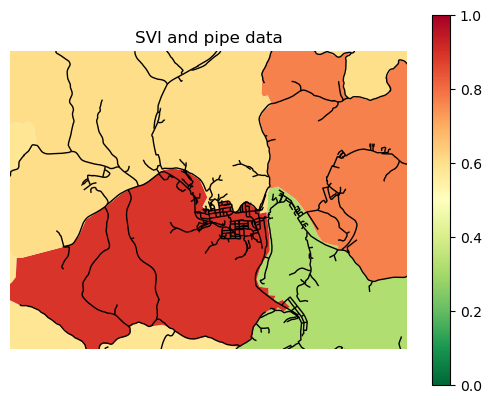

In [20]:
# Plot SVI data and pipes (higher values of SVI are associated with higher vulnerability)
ax = svi_data.plot(column='RPL_THEMES', label='SVI data', cmap='RdYlGn_r', vmin=0, vmax=1, legend=True)
ax = wn_gis.pipes.plot(color='black', linewidth=1, ax=ax)
ax.set_title('SVI and pipe data')
tmp = ax.axis('off')
# Comment/uncomment the following 2 lines to change the zoom on the network graphic
tmp = ax.set_xlim(zoom_coords[0])
tmp = ax.set_ylim(zoom_coords[1])

## Expand the size of each landslide using a buffer
Each landslide is extended to include the surrounding 1000 ft, to create a region that might be impacted by an individual landslide.  The distance unit for buffering matches the distance unit of the CRS (ft).
This assumption could be replaced with detailed landslide analysis that includes slope, soil type, weather conditions, and pipe material. 

In [21]:
# Create a GeoDataFrame to hold information used in landslide scenarios (initially copied from landslide_data)
# Buffer each landslide polygon by 1000 ft
landslide_scenarios = landslide_data.copy()
landslide_scenarios['geometry'] = landslide_data.buffer(1000)

In [22]:
# Add a prefix to the landslide scenario index to indicate the scenario name
landslide_scenarios.index = 'LS-' + landslide_scenarios.index.astype(str)

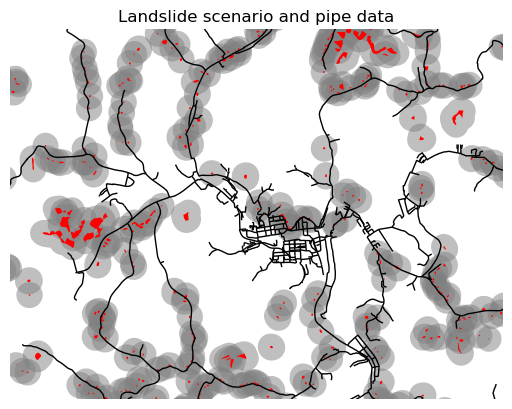

In [23]:
# Plot the landslide data, region included in each landslide scenario, and pipes
ax = landslide_scenarios.plot(color='gray', alpha=0.5)
ax = landslide_data.plot(color='red', label='Landslide data', ax=ax)
ax = wn_gis.pipes.plot(color='black', linewidth=1, ax=ax)
ax.set_title('Landslide scenario and pipe data')
tmp = ax.axis('off')
# Comment/uncomment the following 2 lines to change the zoom on the network graphic
tmp = ax.set_xlim(zoom_coords[0])
tmp = ax.set_ylim(zoom_coords[1])

# Geospatial Intersects
In this section, landslide scenario and SVI data are interested with pipes and junctions in the `WaterNetworkModel`.

## Identify pipes that intersect each landslide
Landslide polygons are intersected with pipes to obtain a list of pipes that intersect each landslide.  <font color='red'>This information is used to to define the pipes that are closed in each landslide scenario.</font> The pipe attribute `length` is also included in the intersection to gather statistics on the pipe length that intersects each landslide.  

In [24]:
# Use the intersect function to determine pipes and pipe length that intersects each landslide
A = landslide_scenarios
B = wn_gis.pipes
B_value = 'length'
landslide_intersect = wntr.gis.intersect(A, B, B_value)

# Print results in order of descending total pipe length
landslide_intersect.sort_values('sum', ascending=False).head()

,intersections,values,n,sum,min,max,mean
LS-6470,"[P-145, P-190, P-389]","[6571.530672, 5059.2590712, 2437.31796]",3,14068.107703,2437.317960,6571.530672,4689.369234
LS-6471,"[P-145, P-190, P-389]","[6571.530672, 5059.2590712, 2437.31796]",3,14068.107703,2437.317960,6571.530672,4689.369234
LS-6456,"[P-145, P-190, P-389]","[6571.530672, 5059.2590712, 2437.31796]",3,14068.107703,2437.317960,6571.530672,4689.369234
LS-5063,"[P-244, P-83]","[12708.2156808, 520.2234960000001]",2,13228.439177,520.223496,12708.215681,6614.219588
LS-5064,"[P-244, P-83]","[12708.2156808, 520.2234960000001]",2,13228.439177,520.223496,12708.215681,6614.219588


In [25]:
# Add the intersection results to the landslide scenario data
landslide_scenarios[['intersections', 'n', 'total pipe length']] = landslide_intersect[['intersections', 'n', 'sum']]

# Print results in order of descending total pipe length
landslide_scenarios.sort_values('total pipe length', ascending=False).head()

,Type,QUADRANGLE,Confidence_Ranking,Shape_Length,Shape_Area,geometry,intersections,n,total pipe length
LS-6470,Landslide,Oil Springs,3,505.785629,17813.235857,"POLYGON ((5731632.245 3843127.579, 5731676.251...","[P-145, P-190, P-389]",3,14068.107703
LS-6471,Landslide,Oil Springs,3,885.366978,46428.920611,"POLYGON ((5731968.886 3842927.394, 5731968.570...","[P-145, P-190, P-389]",3,14068.107703
LS-6456,Landslide,Oil Springs,3,731.639387,40250.058481,"POLYGON ((5732906.128 3842944.427, 5732888.288...","[P-145, P-190, P-389]",3,14068.107703
LS-5063,Landslide,SITKA,3,432.545161,12300.359938,"POLYGON ((5762828.918 3877978.663, 5762925.073...","[P-244, P-83]",2,13228.439177
LS-5064,Landslide,SITKA,3,374.893710,8458.630241,"POLYGON ((5763551.762 3877868.449, 5763622.783...","[P-244, P-83]",2,13228.439177


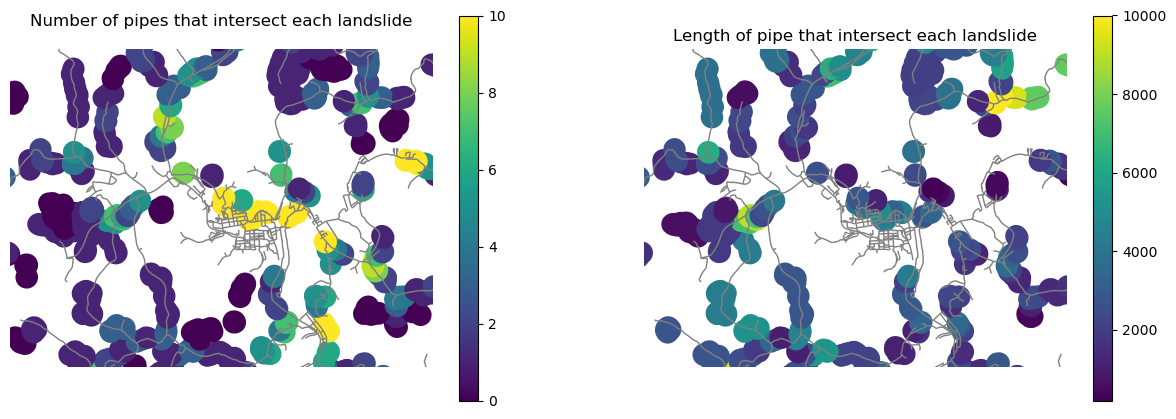

In [26]:
# Plot intersection results
fig, axes = plt.subplots(1,2, figsize=(15,5))

wn_gis.pipes.plot(color='gray', linewidth=1, ax=axes[0])
landslide_scenarios.plot(column='n', vmax=10, legend=True, ax=axes[0])
tmp = axes[0].set_title('Number of pipes that intersect each landslide')
tmp = axes[0].axis('off')
# Comment/uncomment the following 2 lines to change the zoom on the network graphic
tmp = axes[0].set_xlim(zoom_coords[0])
tmp = axes[0].set_ylim(zoom_coords[1])

wn_gis.pipes.plot(color='gray', linewidth=1, ax=axes[1])
landslide_scenarios.plot(column='total pipe length', vmax=10000, legend=True, ax=axes[1])
tmp = axes[1].set_title('Length of pipe that intersect each landslide')
tmp = axes[1].axis('off')
# Comment/uncomment the following 2 lines to change the zoom on the network graphic
tmp = axes[1].set_xlim(zoom_coords[0])
tmp = axes[1].set_ylim(zoom_coords[1])

## Identify landslides that intersect each pipe
Pipes are intersected with landslides to obtain a list of landslides that intersect each pipe. The landslide attribute `Confidence_Ranking` is also included in the intersection to gather statistics on landslide confidence for each pipe.  <font color='red'>While this information is not used in the analysis below, this type of information could be used to inform uncertainty or probability of damage.</font>

**Note that `Confidence_Ranking` has a value of 3 ("Landslide likely at or near the specified location") for each landslide in region of interest. Since the values are uniform in this dataset, the intersected sum, min, max, and mean are all the same value.** More information on Confidence ranking can be found at https://kgs.uky.edu/kgsmap/helpfiles/landslide_help.shtm.  

In [27]:
# Use the intersect function to determine landslides and landslide confidence ranking that intersects each pipe
A = wn_gis.pipes
B = landslide_scenarios
B_value = 'Confidence_Ranking'
pipe_intersect = wntr.gis.intersect(A, B, B_value)

# Print results in order of descending number of intersections.
pipe_intersect.sort_values('n', ascending=False).head()

,intersections,values,n,sum,min,max,mean,weighted_mean
P-449,"[LS-5086, LS-5087, LS-5088, LS-5125, LS-5126, ...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...",25,75.0,3.0,3.0,3.0,3.0
P-517,"[LS-4553, LS-4554, LS-4555, LS-4556, LS-4557, ...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...",23,69.0,3.0,3.0,3.0,3.0
P-722,"[LS-6831, LS-6832, LS-6833, LS-6834, LS-6835, ...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...",23,69.0,3.0,3.0,3.0,3.0
P-837,"[LS-10295, LS-10307, LS-10308, LS-10309, LS-10...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...",23,69.0,3.0,3.0,3.0,3.0
P-442,"[LS-6836, LS-6837, LS-6838, LS-6839, LS-6840, ...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...",20,60.0,3.0,3.0,3.0,3.0


In [28]:
# Add the intersection results to the GIS pipe data
wn_gis.pipes[['intersections', 'n', 'Confidence_Ranking']] = pipe_intersect[['intersections', 'n', 'mean']]

# Print results in order of descending number of intersections
wn_gis.pipes.sort_values('n', ascending=False).head()

,link_type,start_node_name,end_node_name,check_valve,diameter,initial_status,length,minor_loss,roughness,geometry,intersections,n,Confidence_Ranking
P-449,Pipe,J-276,J-616,False,0.1016,Open,6482.077968,0.0,150.0,"LINESTRING (5760308.720 3869886.000, 5760219.9...","[LS-5086, LS-5087, LS-5088, LS-5125, LS-5126, ...",25,3.0
P-517,Pipe,J-581,J-677,False,0.1524,Open,7388.440087,0.0,100.0,"LINESTRING (5728134.870 3878198.000, 5728149.0...","[LS-4553, LS-4554, LS-4555, LS-4556, LS-4557, ...",23,3.0
P-722,Pipe,J-612,J-551,False,0.1016,Open,2962.692576,0.0,100.0,"LINESTRING (5768267.590 3848120.000, 5768281.8...","[LS-6831, LS-6832, LS-6833, LS-6834, LS-6835, ...",23,3.0
P-837,Pipe,J-236,J-860,False,0.1016,Open,7194.294984,0.0,100.0,"LINESTRING (5728952.110 3898156.000, 5725889.4...","[LS-10295, LS-10307, LS-10308, LS-10309, LS-10...",23,3.0
P-442,Pipe,J-454,J-607,False,0.0762,Open,2015.419896,0.0,150.0,"LINESTRING (5778153.330 3852424.000, 5777683.2...","[LS-6836, LS-6837, LS-6838, LS-6839, LS-6840, ...",20,3.0


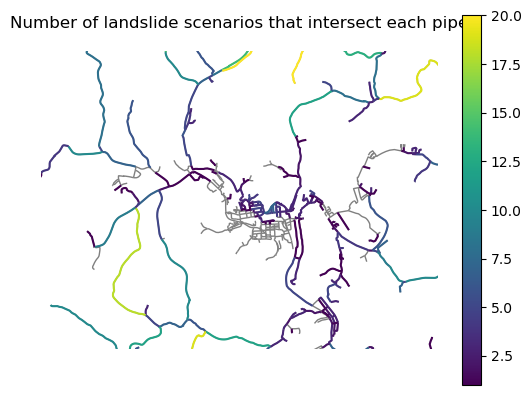

In [29]:
# Plot intersection results
ax = wn_gis.pipes.plot(color='gray', linewidth=1, zorder=1)
wn_gis.pipes[wn_gis.pipes['n'] > 0].plot(column='n', vmax=20, legend=True, ax=ax)
tmp = ax.set_title('Number of landslide scenarios that intersect each pipe')
tmp = ax.axis('off')
# Comment/uncomment the following 2 lines to change the zoom on the network graphic
tmp = ax.set_xlim(zoom_coords[0])
tmp = ax.set_ylim(zoom_coords[1])

## Assign social vulnerability to each junction
Junctions are intersected with SVI to determine the social vulnerability of the population at each junction.  The SVI data attribute `RPL_THEMES` is included in the intersection. <font color='red'>This information is used to determine the social vulnerability of individuals that experience water service disruptions.</font>

The SVI data column `RPL_THEMES` ranks vulnerability across socioeconomic status, household characteristics, racial and ethnic minority status, and housing type and transportation. The value ranges between 0 and 1, where higher values are associated with higher vulnerability.

**Note that since each junction only intersects one census tract, the SVI sum, min, max, and mean are all the same value.**

In [30]:
# Use the intersect function to determine SVI of each junction.  
A = wn_gis.junctions
B = svi_data
B_value = 'RPL_THEMES'
junction_svi = wntr.gis.intersect(A, B, B_value)

junction_svi.head()

,intersections,values,n,sum,min,max,mean
J-1,[791],[0.6031],1,0.6031,0.6031,0.6031,0.6031
J-10,[787],[0.6015],1,0.6015,0.6015,0.6015,0.6015
J-100,[791],[0.6031],1,0.6031,0.6031,0.6031,0.6031
J-101,[791],[0.6031],1,0.6031,0.6031,0.6031,0.6031
J-102,[790],[0.8942],1,0.8942,0.8942,0.8942,0.8942


In [31]:
# Add the intersection results (SVI value) to the GIS junction data
wn_gis.junctions['RPL_THEMES'] = junction_svi['mean']

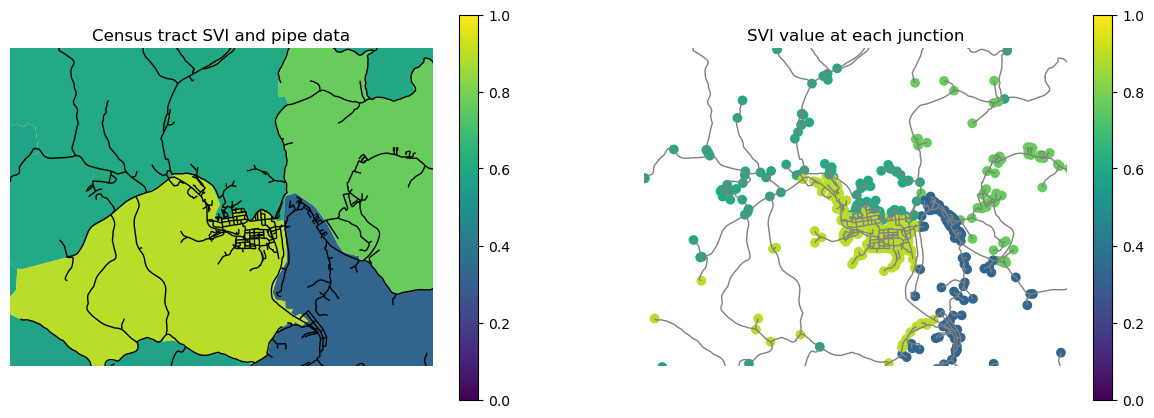

In [32]:
# Plot SVI for each census tract and SVI assigned to each junction
fig, axes = plt.subplots(1,2, figsize=(15,5))

svi_data.plot(column='RPL_THEMES', label='SVI data', vmin=0, vmax=1, legend=True, ax=axes[0])
wn_gis.pipes.plot(color='black', linewidth=1, ax=axes[0])
tmp = axes[0].set_title('Census tract SVI and pipe data')
tmp = axes[0].axis('off')
# Comment/uncomment the following 2 lines to change the zoom on the network graphic
tmp = axes[0].set_xlim(zoom_coords[0])
tmp = axes[0].set_ylim(zoom_coords[1])

wn_gis.pipes.plot(color='gray', linewidth=1, ax=axes[1])
wn_gis.junctions.plot(column='RPL_THEMES', vmin=0, vmax=1, legend=True, ax=axes[1])
tmp = axes[1].set_title('SVI value at each junction')
tmp = axes[1].axis('off')
# Comment/uncomment the following 2 lines to change the zoom on the network graphic
tmp = axes[1].set_xlim(zoom_coords[0])
tmp = axes[1].set_ylim(zoom_coords[1])

# Hydraulic Simulations
The following section runs hydraulic simulations for the baseline (no landslide) and landslide scenarios. A subset of landslide scenarios is run to simply the tutorial.  Simulation results are stored for later analysis.

In [33]:
# Create a function to setup the WaterNetworkModel for hydraulic simulations
def model_setup(inp_file):
    wn = wntr.network.WaterNetworkModel(inp_file)
    wn.options.hydraulic.demand_model = 'PDD'
    wn.options.hydraulic.required_pressure = 20 # m
    wn.options.hydraulic.minimum_pressure  = 0 # m
    wn.options.time.duration = 48*3600 # s (48 hour simulation)
    wn.options.time.hydraulic_timestep = 600 # sec
    wn.options.hydraulic.trials = 100
    wn.options.hydraulic.unbalanced = 'STOP' 
    return wn

## Run baseline simulation

In [34]:
# Run a baseline simulation, with no landslide or damage.  
wn = model_setup(inp_file)
sim = wntr.sim.EpanetSimulator(wn)
baseline_results = sim.run_sim()

In [35]:
# View a subset of the simulation results
baseline_results.node['pressure'].head()

name,J-1,J-10,J-100,J-101,J-102,J-103,J-104,J-105,J-106,J-107,...,T-12,T-13,T-2,T-3,T-4,T-5,T-6,T-7,T-8,T-9
0,74.436096,93.883575,75.054901,56.504501,79.781960,80.306419,80.960396,76.481995,71.050392,48.732750,...,48.268768,21.482943,25.196871,20.663641,25.789127,40.953812,31.307989,43.370964,37.115768,45.291481
3600,71.583282,93.939644,73.497856,54.948952,78.656242,79.054047,79.711792,75.934662,68.466568,46.062962,...,48.321487,22.351206,26.595203,19.959740,25.629583,41.057934,33.646061,40.651207,38.649590,42.405293
7200,71.449715,94.030022,72.485847,53.937553,77.752258,78.046600,78.707199,75.513870,66.399460,43.925659,...,48.408295,23.295893,27.923252,19.290199,25.508699,41.154205,35.558857,38.471394,38.540649,42.290306
10800,71.263786,94.134460,74.273613,55.725315,77.078163,77.290459,77.952995,75.236008,64.879868,42.352898,...,48.513699,24.277452,29.176683,18.834879,25.407606,41.241272,37.062965,36.864666,38.454605,42.112232
14400,71.160576,94.231010,73.759811,55.210762,77.132256,77.309578,77.974609,75.427826,64.030319,41.448414,...,48.615646,25.254507,29.768871,18.834879,25.306477,41.356503,38.228386,35.928051,38.302971,42.021259


In [36]:
# get pressure, demand, and tank water level
# id's of node and tank to get results later (as an example)
tank_id = ['T-13']
node_id = ['J-860']
indexT = 0
indexN = 0

node_pressure = baseline_results.node['pressure'][node_id[indexN]]
node_demand = baseline_results.node['demand'][node_id[indexN]]
tank_pressure = baseline_results.node['pressure'][tank_id[indexT]]
time_hours = node_pressure.index / 3600  # Convert seconds to hours

## Run landslide scenarios
Here we will choose one scenario as example 'LS-4516'

              Type QUADRANGLE  Confidence_Ranking  Shape_Length    Shape_Area  \
LS-4516  Landslide    REDBUSH                   3    694.510154  33666.712606   

                                                  geometry  \
LS-4516  POLYGON ((5739295.519 3871202.865, 5739367.448...   

                 intersections  n  total pipe length  
LS-4516  [P-379, P-686, P-878]  3        6314.620238  


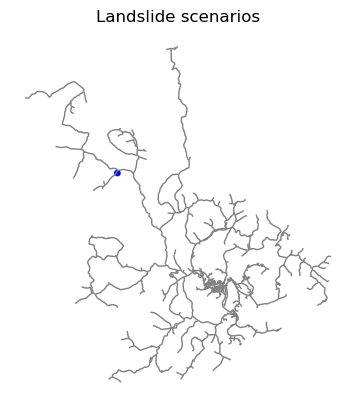

In [37]:
# Plot the location of landslides used in the analysis
landslide_scenarios_1 = landslide_scenarios.loc[['LS-4516'],:] 
print(landslide_scenarios_1)
ax = landslide_scenarios_1.plot(color='blue')
wn_gis.pipes.plot(color='gray', linewidth=1, ax=ax)
tmp = ax.set_title('Landslide scenarios')
tmp = ax.axis('off')

### Create a new model closing only the first pipe

In [38]:
# Run a hydraulic simulation for the selected scenario closing just the first pipe
wn = model_setup(inp_file)

# close the first pipe
pipe_i = landslide_scenarios_1['intersections'].iloc[0][1]
pipe_object = wn.get_link(pipe_i)
pipe_object.initial_status = 'CLOSED'

# run simulation
sim = wntr.sim.EpanetSimulator(wn)
landslide_results = sim.run_sim()


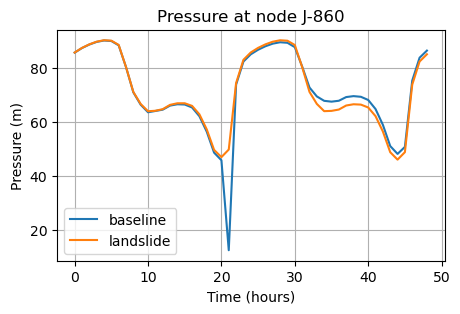

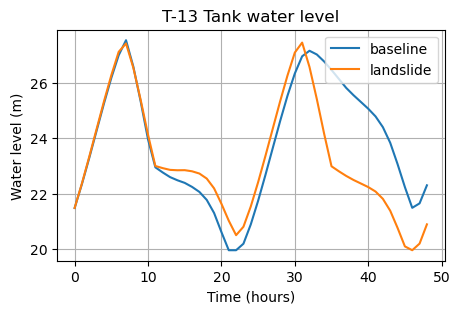

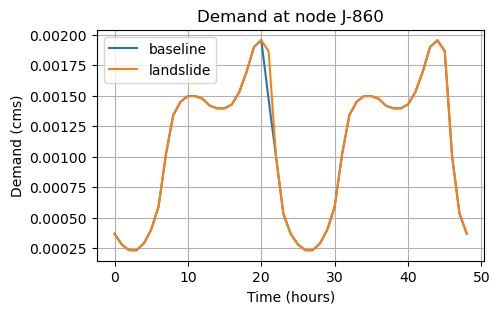

In [39]:
# get new results
node_demand_1 = landslide_results.node['demand'][node_id[indexN]]
node_pressure_1 = landslide_results.node['pressure'][node_id[indexN]]
tank_pressure_1 = landslide_results.node['pressure'][tank_id[indexT]]

# plot pressure at a given node for the base and landslide scenarios
# Plot timeseries of a given node
plt.figure(figsize=(5,3)) 
plt.plot(time_hours, node_pressure)
plt.plot(time_hours, node_pressure_1)
# Formatting the plot
plt.xlabel('Time (hours)')
plt.ylabel('Pressure (m)')
plt.title('Pressure at node ' + node_id[indexN])
plt.legend(['baseline','landslide'])
plt.grid(True)

# plot tank head for the base and landslide scenarios
# Plot timeseries of a given node
plt.figure(figsize=(5,3)) 
plt.plot(time_hours, tank_pressure)
plt.plot(time_hours, tank_pressure_1)
# Formatting the plot
plt.xlabel('Time (hours)')
plt.ylabel('Water level (m)')
plt.title( tank_id[indexT] + ' Tank water level')
plt.legend(['baseline','landslide'])
plt.grid(True)

# demand
plt.figure(figsize=(5,3)) 
plt.plot(time_hours, node_demand)
plt.plot(time_hours, node_demand_1)
# Formatting the plot
plt.xlabel('Time (hours)')
plt.ylabel('Demand (cms)')
plt.title('Demand at node ' + node_id[indexN])
plt.legend(['baseline','landslide'])
plt.grid(True)


### Create a new model and close all the pipes in that scenario

In [40]:
# create a new model
wn = model_setup(inp_file)

# save the new .inp file
# close all pipes in that scenario
for pipe_i in landslide_scenarios_1['intersections'].iloc[0]:
    pipe_object = wn.get_link(pipe_i)
    pipe_object.initial_status = 'CLOSED'

# save new .inp file
wntr.network.write_inpfile(wn, 'ky10_LS.inp')

# run simulation
sim = wntr.sim.EpanetSimulator(wn)
landslide_results = sim.run_sim(convergence_error=True)

node_demand_1 = landslide_results.node['demand'][node_id[indexN]]
node_pressure_1 = landslide_results.node['pressure'][node_id[indexN]]
tank_pressure_1 = landslide_results.node['pressure'][tank_id[indexT]]


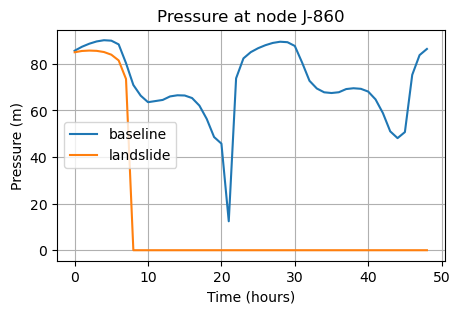

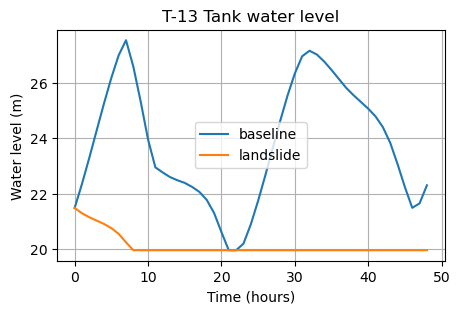

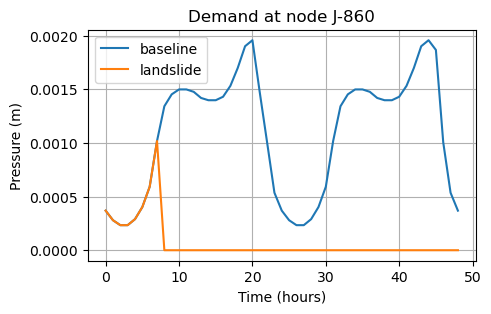

In [41]:
# plot pressure at a given node for the base and landslide scenarios
plt.figure(figsize=(5,3)) 
plt.plot(time_hours, node_pressure)
plt.plot(time_hours, node_pressure_1)
# Formatting the plot
plt.xlabel('Time (hours)')
plt.ylabel('Pressure (m)')
plt.title('Pressure at node ' + node_id[indexN])
plt.legend(['baseline','landslide'])
plt.grid(True)

# plot tank water level for the base and landslide scenarios
plt.figure(figsize=(5,3)) 
plt.plot(time_hours, tank_pressure)
plt.plot(time_hours, tank_pressure_1)
# Formatting the plot
plt.xlabel('Time (hours)')
plt.ylabel('Water level (m)')
plt.title( tank_id[indexT] + ' Tank water level')
plt.legend(['baseline','landslide'])
plt.grid(True)

# plot demand for the base and landslide scenarios
plt.figure(figsize=(5,3)) 
plt.plot(time_hours, node_demand)
plt.plot(time_hours, node_demand_1)
# Formatting the plot
plt.xlabel('Time (hours)')
plt.ylabel('Pressure (m)')
plt.title('Demand at node ' + node_id[indexN])
plt.legend(['baseline','landslide'])
plt.grid(True)

## Calculate water availability

### For individual node as an example

SR for selected junctions: 0.06


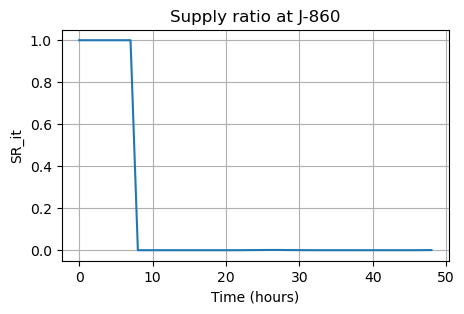

In [42]:
# calculate the supply ratio

# individual node as example
plt.figure(figsize=(5,3)) 
SR_it = node_demand_1/node_demand
plt.plot(time_hours, SR_it)
# Formatting the plot
plt.xlabel('Time (hours)')
plt.ylabel('SR_it')
plt.title('Supply ratio at ' + node_id[indexN])
plt.grid(True)

# given node at all time steps
SR_i = sum(node_demand_1)/sum(node_demand)
print(f"SR for selected junctions: {SR_i:.2f}")

### For all nodes

In [43]:
# baseline scenario
# Access the demand data
demand_df = baseline_results.node['demand']  # This is a Pandas DataFrame

# Get a list of only junction nodes (exclude tanks and pumps)
demand_df = demand_df[wn.junction_name_list]  # This returns only junction node IDs

# Sum up all demands across all rows (i.e., summing demand over time for each node)
total_demand_per_node = demand_df.sum(axis=0)  # Sum rows for each node

# Sum up all demands across all nodes and all time steps
total_demand = demand_df.sum().sum()  # Sum all elements in the DataFrame

print("Total demand in the network:", total_demand)

# landslide scenario
# Access the demand data
demand_df_LS = landslide_results.node['demand']  # This is a Pandas DataFrame

# Get a list of only junction nodes (exclude tanks and pumps)
demand_df_LS = demand_df_LS[wn.junction_name_list]  # This returns only junction node IDs
# Sum up all demands across all rows (i.e., summing demand over time for each node)
total_demand_per_node_LS = demand_df_LS.sum(axis=0)  # Sum rows for each node

# Sum up all demands across all nodes and all time steps
total_demand_LS = demand_df_LS.sum().sum()  # Sum all elements in the DataFrame

print("Total demand in the network LS:", total_demand_LS)


Total demand in the network: 4.514331
Total demand in the network LS: 4.140654


Text(0, 0.5, 'SR_i')

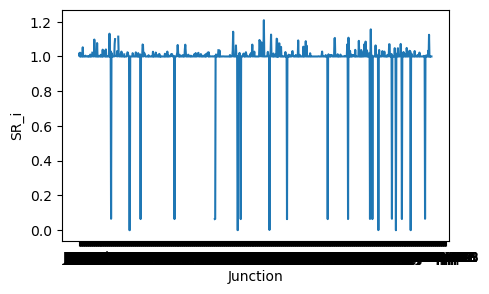

In [44]:
# Get SR for each node
SR_I = total_demand_per_node_LS/total_demand_per_node

# Create a plot of total demand per junction
plt.figure(figsize=(5, 3))
plt.plot(SR_I)
plt.xlabel('Junction')
plt.ylabel('SR_i')

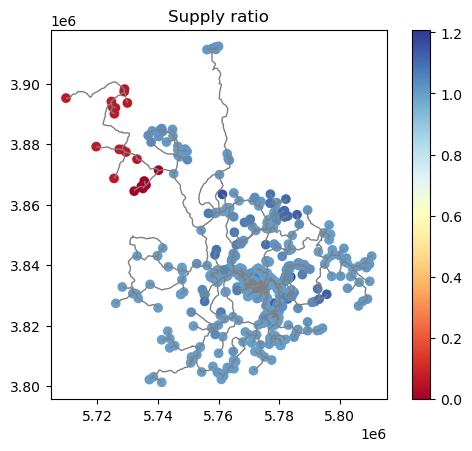

In [45]:
# Make spatial plot of SRs
wn_gis.junctions['supply_ratio'] = SR_I
ax = wn_gis.pipes.plot(color='gray', linewidth=1) # pipes
ax = wn_gis.junctions.plot(ax = ax, column = 'supply_ratio', cmap='RdYlBu', vmin = 0, vmax = max(SR_I), legend=True) # junction wsa
tmp = ax.set_title('Supply ratio')

## Get SVI for impacted junctions

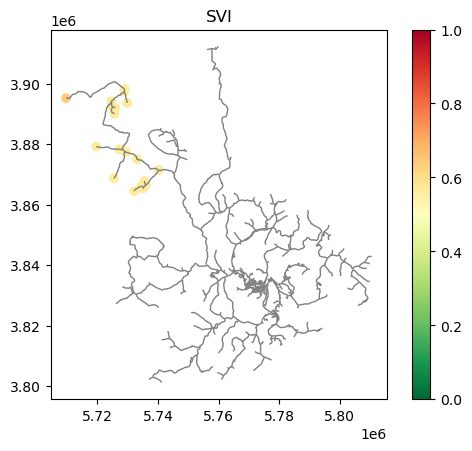

In [46]:
impacted_junctions = SR_I < 0.5
ax = wn_gis.pipes.plot(color='gray', linewidth=1) # pipes
ax = wn_gis.junctions.loc[impacted_junctions,:].plot(ax = ax, column='RPL_THEMES', cmap='RdYlGn_r', vmin=0, vmax=1, legend=True)
tmp = ax.set_title('SVI')


In [47]:
# calculate the averate SVI of the impacted junctions and the remaining junctions
impacted_junctions_SVI = wn_gis.junctions.loc[impacted_junctions, 'RPL_THEMES'].mean()
non_impacted_junctions_SVI = wn_gis.junctions.loc[~wn_gis.junctions.index.isin(impacted_junctions), 'RPL_THEMES'].mean()

print(f"Average SVI for Impacted Junctions: {impacted_junctions_SVI:.2f}")
print(f"Average SVI for Non-Impacted Junctions: {non_impacted_junctions_SVI:.2f}")


Average SVI for Impacted Junctions: 0.57
Average SVI for Non-Impacted Junctions: 0.69
